<h1>Objective :</h1>
<h3>The goal is to predict whether a food delivery will be "Fast" or "Delayed" based on various features like customer location, restaurant location, weather, traffic conditions, etc. This dataset will be used to explore CNN and evaluation/validation techniques.</h3>

<h1>Phase 1<br>Data Preprocessing</h1>(2 steps)

<h3>Step 1 - Data Import and Cleaning</h3>

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# from mpl_toolkits.mplot3d import Axes3D
# from sklearn.cluster import KMeans
# from scipy.cluster.hierarchy import dendrogram, linkage
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# from sklearn.linear_model import LogisticRegression
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

In [161]:
data=pd.read_csv('Food_Delivery_Time_prediction.csv')
d=data.copy()
d.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [162]:
d.isnull().sum()

Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64

Null values do not exist in any column<br>
Now checking for incorrect data

In [163]:
#drop duplicate and empty rows of Order_ID column
d.dropna(subset=['Order_ID'])
d.drop_duplicates(subset='Order_ID', keep='first')
# drop incorrect data for Order_ID column
d.drop(d[ d['Order_ID'].str.match(r'^ORD\d{4}$')==False ].index, inplace=True) 
# here if inplace=True not used then the changes will not be applied to the original dataframe 

#drop rows with null values in Customer_Location column
d.dropna(subset=['Customer_Location'], inplace=True)

#drop rows with null values in Restaurant_Location column
d.dropna(subset=['Restaurant_Location'], inplace=True)

# # distance values all greater than 0
# d.loc[d['Distance']<=0,'Distance']=np.mean(d[d['Distance']>0]['Distance'])

# fill null values in Weather_Conditions with 'Sunny'
# Weather_Conditions values should be one of the following
d['Weather_Conditions'].fillna('Sunny')
valid_weather_conditions = ['Sunny', 'Rainy', 'Snowy', 'Cloudy']
d.loc[~d['Weather_Conditions'].isin(valid_weather_conditions), 'Weather_Conditions'] = 'Sunny'

# fill null values in Traffic_Conditions with 'Medium'
# Traffic_Conditions values should be one of the following
d['Traffic_Conditions'].fillna('Medium')
valid_traffic_conditions = ['Low', 'Medium', 'High']
d.loc[~d['Traffic_Conditions'].isin(valid_traffic_conditions), 'Traffic_Condisions'] = 'Medium'

# # Deliver_Person_Experience values should be positive and non-zero
# d.loc[d['Delivery_Person_Experience']<=0,'Delivery_Person_Experience']=np.mean(d.loc[d['Delivery_Person_Experience']>0,'Delivery_Person_Experience'])

# fill null values in Order_Priority with 'Medium'
# Order_Priority values should be one of the following
d['Order_Priority'].fillna('Medium')
valid_order_priority = ['Low', 'Medium', 'High']
d.loc[~d['Order_Priority'].isin(valid_order_priority), 'Order_Priority'] = 'Medium'

# fill null values in Order_Time with 'Night'
# Order_Time values should be one of the following
d['Order_Time'].fillna('Night')
valid_order_time = ['Afternoon', 'Night', 'Evening', 'Morning']
d.loc[~d['Order_Time'].isin(valid_order_time), 'Order_Time'] = 'Night'

# fill null values in Vehicle_Type with 'Bike'
# Vehicle_Type values should be one of the following
d['Vehicle_Type'].fillna('Bike')
valid_vehicle_type = ['Car', 'Bike', 'Bicycle']
d.loc[~d['Vehicle_Type'].isin(valid_vehicle_type), 'Vehicle_Type'] = 'Bike'


In [164]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54,NaN
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02,NaN
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17,NaN
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23,NaN
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,Cloudy,High,8,Medium,Night,Bike,4.7,4.0,50.39,1432.26,66.34,NaN
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,Snowy,Medium,8,Low,Night,Bicycle,3.0,3.6,90.54,1720.25,40.27,NaN
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,Snowy,High,4,Medium,Afternoon,Bike,2.9,3.4,73.20,1356.58,5.10,NaN
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,Rainy,High,9,Low,Night,Car,3.9,4.8,53.94,354.39,85.25,NaN


In [165]:
# Setting numeric values to column Weather_Conditions
weather_map = {'Sunny': 0, 'Rainy': 1, 'Snowy': 2, 'Cloudy': 3}
d['Weather_Conditions'] = d['Weather_Conditions'].map(weather_map)

# Setting numeric values to column Traffic_Conditions
traffic_map = {'Low': 0, 'Medium': 1, 'High': 2}
d['Traffic_Conditions'] = d['Traffic_Conditions'].map(traffic_map)

# Setting numeric values to column Vehicle_Type
vehicle_type_map = {'Bicycle': 0, 'Bike': 1, 'Car': 2}
d['Vehicle_Type'] = d['Vehicle_Type'].map(vehicle_type_map)

In [166]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,1,4,Medium,Afternoon,2,4.1,3.0,26.22,1321.10,81.54,NaN
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,3,1,8,Low,Night,2,4.5,4.2,62.61,152.21,29.02,NaN
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,1,9,High,Night,1,3.3,3.4,48.43,1644.38,64.17,NaN
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,3,0,2,Medium,Evening,1,3.2,3.7,111.63,541.25,79.23,NaN
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,2,6,Low,Night,1,3.5,2.8,32.38,619.81,2.34,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,3,2,8,Medium,Night,1,4.7,4.0,50.39,1432.26,66.34,NaN
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,2,1,8,Low,Night,0,3.0,3.6,90.54,1720.25,40.27,NaN
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,2,2,4,Medium,Afternoon,1,2.9,3.4,73.20,1356.58,5.10,NaN
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,1,2,9,Low,Night,2,3.9,4.8,53.94,354.39,85.25,NaN


In [167]:
# Standardization
s=StandardScaler()
d['Distance_Scaled'] = s.fit_transform(d[['Distance']])
d['Delivery_Time_Scaled'] = s.fit_transform(d[['Delivery_Time']])
# StandardScaler().fit_transform() expects a 2D array or DataFrame, but you passed a Series (d['Distance']), which is 1D.
# So pass a DataFrame with double brackets d[['Distance']]

In [168]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions,Distance_Scaled,Delivery_Time_Scaled
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,1,4,Medium,Afternoon,2,4.1,3.0,26.22,1321.10,81.54,NaN,-1.454738,-1.487932
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,3,1,8,Low,Night,2,4.5,4.2,62.61,152.21,29.02,NaN,1.439192,-0.264987
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,1,9,High,Night,1,3.3,3.4,48.43,1644.38,64.17,NaN,-0.666417,-0.741529
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,3,0,2,Medium,Evening,1,3.2,3.7,111.63,541.25,79.23,NaN,0.335835,1.382411
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,2,6,Low,Night,1,3.5,2.8,32.38,619.81,2.34,NaN,-0.700119,-1.280915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,3,2,8,Medium,Night,1,4.7,4.0,50.39,1432.26,66.34,NaN,1.805512,-0.675660
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,2,1,8,Low,Night,0,3.0,3.6,90.54,1720.25,40.27,NaN,-0.792431,0.673647
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,2,2,4,Medium,Afternoon,1,2.9,3.4,73.20,1356.58,5.10,NaN,1.335157,0.090908
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,1,2,9,Low,Night,2,3.9,4.8,53.94,354.39,85.25,NaN,1.840679,-0.556356


<h3>Step 2 - Feature Engineering</h3>

In [169]:
def haversine_formula(coords_array1, coords_array2):
    lat1 = coords_array1[:,0]
    lon1 = coords_array1[:,1]
    lat2 = coords_array2[:,0]
    lon2 = coords_array2[:,1]
    # Convert decimal degrees to radians 
    lat1=np.radians(lat1)
    lon1=np.radians(lon1)
    lat2=np.radians(lat2)
    lon2=np.radians(lon2)
    # Haversine formula 
    lat_diff = lat2 - lat1 
    lon_diff = lon2 - lon1 
    a = np.sin(lat_diff/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon_diff/2)**2
    c = 2 * np.asin(np.sqrt(a)) 
    r = 6371  # Radius of earth in km
    return c * r

def parse_location(loc_str):
    # Remove parentheses and split by comma
    lat, lon = loc_str.strip("()").split(",")
    return float(lat), float(lon)

coords_array1 = d['Customer_Location'].apply(parse_location).tolist()
coords_array1 = np.array(coords_array1)

coords_array2 = d['Restaurant_Location'].apply(parse_location).tolist()
coords_array2 = np.array(coords_array2)

d['Calculated_Distance'] = haversine_formula(coords_array1, coords_array2)

In [170]:
d[['Calculated_Distance']]

,Calculated_Distance
0,775.651198
1,1042.385597
2,476.220706
3,389.912629
4,806.505886
...,...
195,670.130652
196,558.891202
197,106.686689
198,880.580093


In [171]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions,Distance_Scaled,Delivery_Time_Scaled,Calculated_Distance
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,1,4,Medium,Afternoon,2,4.1,3.0,26.22,1321.10,81.54,NaN,-1.454738,-1.487932,775.651198
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,3,1,8,Low,Night,2,4.5,4.2,62.61,152.21,29.02,NaN,1.439192,-0.264987,1042.385597
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,1,9,High,Night,1,3.3,3.4,48.43,1644.38,64.17,NaN,-0.666417,-0.741529,476.220706
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,3,0,2,Medium,Evening,1,3.2,3.7,111.63,541.25,79.23,NaN,0.335835,1.382411,389.912629
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,2,6,Low,Night,1,3.5,2.8,32.38,619.81,2.34,NaN,-0.700119,-1.280915,806.505886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,3,2,8,Medium,Night,1,4.7,4.0,50.39,1432.26,66.34,NaN,1.805512,-0.675660,670.130652
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,2,1,8,Low,Night,0,3.0,3.6,90.54,1720.25,40.27,NaN,-0.792431,0.673647,558.891202
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,2,2,4,Medium,Afternoon,1,2.9,3.4,73.20,1356.58,5.10,NaN,1.335157,0.090908,106.686689
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,1,2,9,Low,Night,2,3.9,4.8,53.94,354.39,85.25,NaN,1.840679,-0.556356,880.580093


In [172]:
delivery_time_mean = np.mean(d['Delivery_Time'])
print(delivery_time_mean)

70.49494999999999


In [173]:
d['Delivery_Time_Binary'] = np.where(d['Delivery_Time'] > delivery_time_mean, 'rush hour', 'non-rush hour')
# 'rush hour' for delivery time greater than mean (Delayed), 'non-rush hour for less than or equal to mean(Fast)

In [174]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions,Distance_Scaled,Delivery_Time_Scaled,Calculated_Distance,Delivery_Time_Binary
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,1,4,Medium,Afternoon,2,4.1,3.0,26.22,1321.10,81.54,NaN,-1.454738,-1.487932,775.651198,non-rush hour
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,3,1,8,Low,Night,2,4.5,4.2,62.61,152.21,29.02,NaN,1.439192,-0.264987,1042.385597,non-rush hour
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,1,9,High,Night,1,3.3,3.4,48.43,1644.38,64.17,NaN,-0.666417,-0.741529,476.220706,non-rush hour
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,3,0,2,Medium,Evening,1,3.2,3.7,111.63,541.25,79.23,NaN,0.335835,1.382411,389.912629,rush hour
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,2,6,Low,Night,1,3.5,2.8,32.38,619.81,2.34,NaN,-0.700119,-1.280915,806.505886,non-rush hour
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,3,2,8,Medium,Night,1,4.7,4.0,50.39,1432.26,66.34,NaN,1.805512,-0.675660,670.130652,non-rush hour
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,2,1,8,Low,Night,0,3.0,3.6,90.54,1720.25,40.27,NaN,-0.792431,0.673647,558.891202,rush hour
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,2,2,4,Medium,Afternoon,1,2.9,3.4,73.20,1356.58,5.10,NaN,1.335157,0.090908,106.686689,rush hour
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,1,2,9,Low,Night,2,3.9,4.8,53.94,354.39,85.25,NaN,1.840679,-0.556356,880.580093,non-rush hour


Correlation between Temperature and Delivery Time: 0.06
Correlation between Humidity and Delivery Time: -0.14


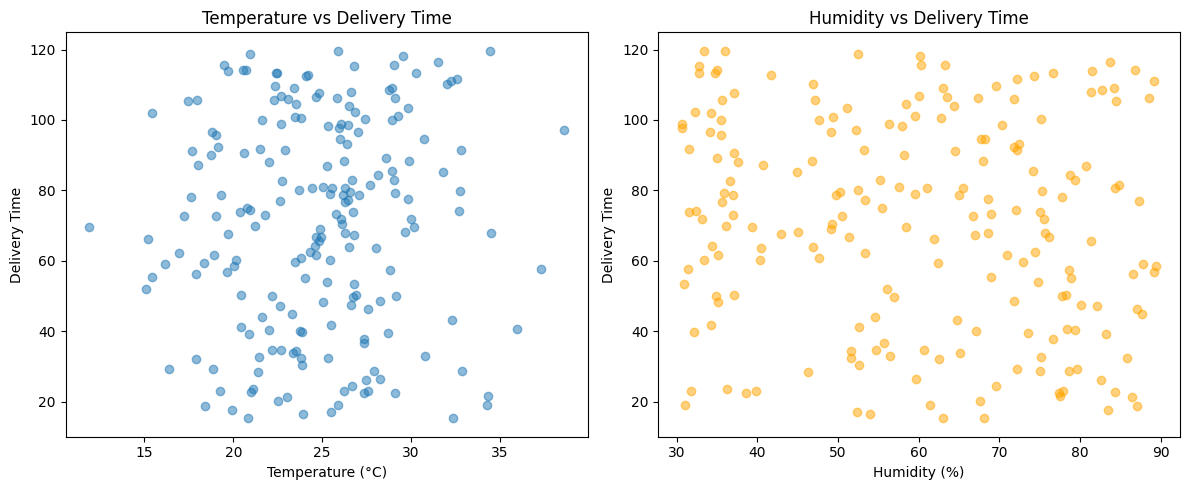

In [175]:
# Assuming the dataset does not already have temperature and humidity columns,
# let's simulate these features for demonstration purposes.

# Add random temperature (in Celsius) and humidity (%) columns
np.random.seed(42)
d['Temperature'] = np.random.normal(loc=25, scale=5, size=len(d))  # mean 25°C, std 5
d['Humidity'] = np.random.uniform(low=30, high=90, size=len(d))    # between 30% and 90%

# Analyze correlation between weather features and delivery time
corr_temp = d['Temperature'].corr(d['Delivery_Time'])
corr_humidity = d['Humidity'].corr(d['Delivery_Time'])

print(f"Correlation between Temperature and Delivery Time: {corr_temp:.2f}")
print(f"Correlation between Humidity and Delivery Time: {corr_humidity:.2f}")

# Visualize the relationship
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(d['Temperature'], d['Delivery_Time'], alpha=0.5)
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('Delivery Time')
axes[0].set_title('Temperature vs Delivery Time')

axes[1].scatter(d['Humidity'], d['Delivery_Time'], alpha=0.5, color='orange')
axes[1].set_xlabel('Humidity (%)')
axes[1].set_ylabel('Delivery Time')
axes[1].set_title('Humidity vs Delivery Time')

plt.tight_layout()
plt.show()

<h1>Phase 2<br> Convolutional Neural Network (CNN)</h1>(3 steps)

<h3>Step 3 - Introduction to CNN</h3>

Epoch 1/10


c:\Users\Princy Pandya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.4444 - loss: 0.8139 - val_accuracy: 0.7500 - val_loss: 0.6900
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5000 - loss: 0.7059 - val_accuracy: 0.7500 - val_loss: 0.6636
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5833 - loss: 0.6841 - val_accuracy: 0.7500 - val_loss: 0.6529
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5278 - loss: 0.6830 - val_accuracy: 0.7500 - val_loss: 0.6430
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5556 - loss: 0.7264 - val_accuracy: 0.7500 - val_loss: 0.6547
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6250 - loss: 0.6891 - val_accuracy: 0.7500 - val_loss: 0.6843
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6250 - loss: 0.6895 - val_accuracy: 0.7500 - val_loss: 0.6833
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5833 - loss: 0.6764 - val_accuracy: 0.7500 - val_loss: 0.6358
Epoch 9/10

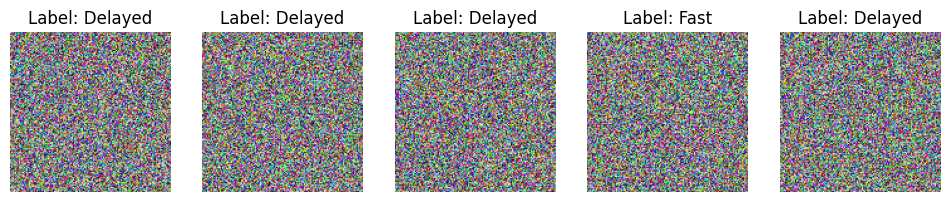

In [176]:
# Example: Load image data and labels
# images: numpy array of shape (num_samples, height, width, channels)
# labels: categorical labels "Fast" or "Delayed" encoded as 0 and 1

# For demonstration, mock image data and labels
num_samples = 100
img_height, img_width = 128, 128
images = np.random.rand(num_samples, img_height, img_width, 3)  # Replace with actual images
labels = np.random.choice([0, 1], size=num_samples)  # 0 = Fast, 1 = Delayed

# Split data into train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# CNN model architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=16, validation_split=0.1)

# Evaluate model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

# Function to visualize 5 random images with explanations
def plot_random_images(images, labels):
    class_names = {0: "Fast", 1: "Delayed"}
    indices = random.sample(range(len(images)), 5)
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(indices):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[idx])
        plt.title(f"Label: {class_names[labels[idx]]}")
        plt.axis('off')
    plt.show()

# Display 5 random sample images with their labels
plot_random_images(images, labels)

<h3>Step 4 - Implementation</h3>

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5833 - loss: 0.7271 - val_accuracy: 0.5625 - val_loss: 0.6905
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5694 - loss: 0.6900 - val_accuracy: 0.5625 - val_loss: 0.6869
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6042 - loss: 0.6881 - val_accuracy: 0.5625 - val_loss: 0.6890
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6042 - loss: 0.6809 - val_accuracy: 0.5625 - val_loss: 0.6855
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6042 - loss: 0.6823 - val_accuracy: 0.5625 - val_loss: 0.6856
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6042 - loss: 0.6863 - val_accuracy: 0.5625 - val_loss: 0.6896
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6042 - loss: 0.6717 - val_accuracy: 0.5625 - val_loss: 0.6852
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6042 - loss: 0.6743 - val_accuracy: 0.5625 - val_loss: 0.6856


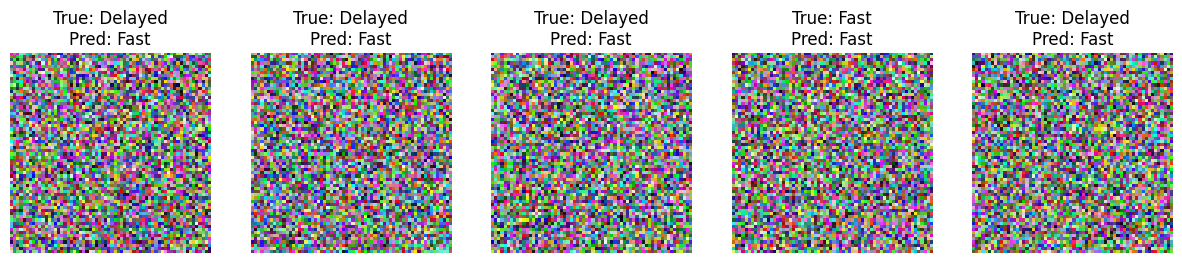

In [177]:
# --- Dataset Preparation: Example mock for image creation ---
# Replace this with the actual images generation from location and delivery data.

def generate_dummy_image(delivery_index):
    # Dummy example: Generate an image with some pattern based on index
    img = np.zeros((64, 64, 3))
    np.random.seed(delivery_index)  # For reproducibility
    img += np.random.rand(64, 64, 3) * 255
    return img.astype(np.uint8)

num_samples = 200
images = np.array([generate_dummy_image(i) for i in range(num_samples)])
labels = np.random.choice([0, 1], size=num_samples)  # 0 = Fast, 1 = Delayed

# Normalize images for CNN input
images = images.astype('float32') / 255.0

# Split into train-test sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# --- CNN Architecture ---

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary output
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train CNN
history = model.fit(x_train, y_train, epochs=15, batch_size=16, validation_split=0.1)

# --- Evaluation ---

# Predict binary classes on test set
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')

# --- Visualization of some random test images with predictions and actual labels ---

class_labels = {0: "Fast", 1: "Delayed"}

def plot_images_with_predictions(x, y_true, y_pred, num=5):
    indices = random.sample(range(len(x)), num)
    plt.figure(figsize=(15, 4))
    for i, idx in enumerate(indices):
        plt.subplot(1, num, i+1)
        plt.imshow(x[idx])
        plt.title(f"True: {class_labels[y_true[idx]]}\nPred: {class_labels[y_pred[idx]]}")
        plt.axis('off')
    plt.show()

plot_images_with_predictions(x_test, y_test, y_pred)


<h3>Step 5 - Model Improvement</h3>

In [178]:
# Example dataset (replace with your actual images and labels)
num_samples = 200
img_height, img_width = 64, 64
channels = 3

def generate_dummy_image(i):
    np.random.seed(i)
    return (np.random.rand(img_height, img_width, channels)*255).astype(np.uint8)

images = np.array([generate_dummy_image(i) for i in range(num_samples)])
labels = np.random.choice([0, 1], size=num_samples)  # 0=Fast, 1=Delayed

# Normalize images
images = images.astype('float32') / 255.0

# Split data
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Hyperparameters to tune
num_filters = 64
kernel_size = (3,3)
learning_rate = 0.001
dropout_rate = 0.5
epochs = 15
batch_size = 16

# Build CNN model with tuned hyperparameters
model = Sequential([
    Conv2D(num_filters, kernel_size, activation='relu', input_shape=(img_height, img_width, channels)),
    MaxPooling2D((2,2)),
    Conv2D(num_filters*2, kernel_size, activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(num_filters*4, kernel_size, activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train CNN
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2)

# Evaluate CNN
y_pred_prob = model.predict(x_test)
y_pred_cnn = (y_pred_prob > 0.5).astype(int).flatten()

# CNN Metrics
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
precision_cnn = precision_score(y_test, y_pred_cnn, zero_division=0)
recall_cnn = recall_score(y_test, y_pred_cnn, zero_division=0)
f1_cnn = f1_score(y_test, y_pred_cnn, zero_division=0)

print(f'\nCNN Performance:')
print(f'Accuracy: {accuracy_cnn:.3f}, Precision: {precision_cnn:.3f}, Recall: {recall_cnn:.3f}, F1-score: {f1_cnn:.3f}')

# --- Logistic Regression on Flattened Data ---

# Flatten images for Logistic Regression
x_train_flat = x_train.reshape((x_train.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))

# Initialize and train Logistic Regression model
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(x_train_flat, y_train)

# Predict and evaluate Logistic Regression
y_pred_lr = log_reg.predict(x_test_flat)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, zero_division=0)
recall_lr = recall_score(y_test, y_pred_lr, zero_division=0)
f1_lr = f1_score(y_test, y_pred_lr, zero_division=0)

print(f'\nLogistic Regression Performance:')
print(f'Accuracy: {accuracy_lr:.3f}, Precision: {precision_lr:.3f}, Recall: {recall_lr:.3f}, F1-score: {f1_lr:.3f}')


Epoch 1/15


c:\Users\Princy Pandya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 - 2s - 184ms/step - accuracy: 0.5208 - loss: 0.7348 - val_accuracy: 0.5625 - val_loss: 0.6862
Epoch 2/15
9/9 - 1s - 63ms/step - accuracy: 0.5833 - loss: 0.6800 - val_accuracy: 0.5625 - val_loss: 0.6887
Epoch 3/15
9/9 - 1s - 69ms/step - accuracy: 0.6042 - loss: 0.6628 - val_accuracy: 0.5625 - val_loss: 0.7119
Epoch 4/15
9/9 - 1s - 60ms/step - accuracy: 0.6181 - loss: 0.6813 - val_accuracy: 0.5625 - val_loss: 0.6857
Epoch 5/15
9/9 - 1s - 57ms/step - accuracy: 0.5972 - loss: 0.6812 - val_accuracy: 0.5625 - val_loss: 0.6848
Epoch 6/15
9/9 - 1s - 58ms/step - accuracy: 0.6181 - loss: 0.6660 - val_accuracy: 0.5625 - val_loss: 0.6884
Epoch 7/15
9/9 - 1s - 57ms/step - accuracy: 0.6111 - loss: 0.6870 - val_accuracy: 0.5625 - val_loss: 0.6860
Epoch 8/15
9/9 - 1s - 58ms/step - accuracy: 0.6181 - loss: 0.6686 - val_accuracy: 0.5625 - val_loss: 0.6848
Epoch 9/15
9/9 - 1s - 61ms/step - accuracy: 0.5833 - loss: 0.6829 - val_accuracy: 0.5625 - val_loss: 0.6849
Epoch 10/15
9/9 - 1s - 63ms/step - acc

<h1>Phase 3<br> Model Evaluation and Validation</h1>(3 steps)

<h3>Step 6 - Cross-Validation</h3>